In [2]:
import numpy as np
import torch
from d2l import torch as d2l
from tqdm import tqdm

In [19]:
""" 
卷积朴素实现
def conv2d(input, weight, bias=None, stride=1, padding=0):
    batch_size, in_channels, in_height, in_width = input.size()
    out_channels, _, kernel_height, kernel_width = weight.size()
    out_height = int((in_height + 2 * padding - kernel_height) / stride) + 1
    out_width = int((in_width + 2 * padding - kernel_width) / stride) + 1
    padded_input = torch.nn.functional.pad(input, (padding, padding, padding, padding))
    output = torch.zeros(batch_size, out_channels, out_height, out_width)
    for b in range(batch_size):
        for c_out in range(out_channels):
            for h_out in range(out_height):
                for w_out in range(out_width):
                    h_start = h_out * stride
                    w_start = w_out * stride
                    h_end = h_start + kernel_height
                    w_end = w_start + kernel_width
                    input_patch = padded_input[b, :, h_start:h_end, w_start:w_end]
                    output[b, c_out, h_out, w_out] = torch.sum(input_patch * weight[c_out]) + (bias[c_out] if bias is not None else 0)
    return output
"""

def conv2d(input, weight, bias=None, stride=1, padding=0):
    padded_input = torch.nn.functional.pad(input, (padding, padding, padding, padding))
    output = torch.nn.functional.conv2d(padded_input, weight, bias=bias, stride=stride)
    return output

In [20]:
"""
ave 池化朴素实现
def avg_pool2d(input, kernel_size, stride=None, padding=0):
    batch_size, channels, height, width = input.size()
    output_height = int((height + 2 * padding - kernel_size) / stride) + 1
    output_width = int((width + 2 * padding - kernel_size) / stride) + 1
    output = torch.zeros(batch_size, channels, output_height, output_width)
    for b in range(batch_size):
        for c in range(channels):
            for i in range(output_height):
                for j in range(output_width):
                    avg_value = torch.mean(
                        input[b, c, i * stride:i * stride + kernel_size, j * stride:j * stride + kernel_size]
                    )
                    output[b, c, i, j] = avg_value
    return output
"""

def avg_pool2d(input, kernel_size, stride=None, padding=0):
    output = torch.nn.functional.avg_pool2d(input, kernel_size, stride=stride, padding=padding)
    return output

In [45]:
class LeNet:
    def __init__(self):
        self.params = self._init_params()
        
    def _init_params(self):
        """初始化参数"""
        def normal(shape):
            return torch.randn(size=shape, device=device) * 0.01
        """输出通道 * 输入通道 * 卷积核边长 * 卷积核边长"""
        W_conv1 = normal((6, 1, 5, 5)); b_conv1 = torch.zeros(6, device=device);
        W_conv2 = normal((16, 6, 5, 5)); b_conv2 = torch.zeros(16, device=device);
        W_h1h2 = normal((16 * 5 * 5, 120)); b_h1h2 = torch.zeros(120, device=device);
        W_h2h3 = normal((120, 84)); b_h2h3 = torch.zeros(84, device=device);
        W_h3y = normal((84, 10)); b_h3y = torch.zeros(10, device=device);
        
        params = [W_conv1,b_conv1, W_conv2, b_conv2, W_h1h2, b_h1h2, W_h2h3, b_h2h3, W_h3y, b_h3y]
        for param in params:
            param.requires_grad_(True)
        return params
    
    def _forward(self, X):
        """推理函数"""
        W_conv1, b_conv1, W_conv2, b_conv2, W_h1h2, b_h1h2, W_h2h3, b_h2h3, W_h3y, b_h3y = self.params
        C1 = torch.sigmoid(conv2d(X, W_conv1, b_conv1, stride=1, padding=2))
        C2 = avg_pool2d(C1, 2, stride=2, padding=0)
        C3 = torch.sigmoid(conv2d(C2, W_conv2, b_conv2, stride=1, padding=0))
        C4 = avg_pool2d(C3, 2, stride=2, padding=0)
        H1 = C4.reshape(C4.size(0), -1)
        H2 = torch.sigmoid(H1 @ W_h1h2 + b_h1h2)
        H3 = torch.sigmoid(H2 @ W_h2h3 + b_h2h3)
        Y = torch.sigmoid(H3 @ W_h3y + b_h3y)
        return Y
    
    def update(self, X, y, lr):
        """更新函数"""
        y_hat = self._forward(X)
        l = self._loss(y_hat, y)
        l.mean().backward()
        """sgd"""
        with torch.no_grad():
            for param in self.params:
                param -= lr * param.grad / X.shape[0]
                param.grad.zero_()
        return l
                
    def _loss(self, y_hat, y):
        """交叉熵损失"""
        return - torch.log(y_hat[range(len(y_hat)), y])
                
    def __call__(self, X):
        return self._forward(X)

In [46]:
net = LeNet()
X = torch.randn(2, 1, 28, 28)
net(X).shape

torch.Size([2, 10])

In [54]:
batch_size, device = 16, 'cpu'
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=28)
net = LeNet()

In [55]:
num_epochs = 5
for epoch in range(num_epochs):
    metrics = [0, 0]
    i = 0
    for X, y in tqdm(train_iter, ncols=100):
        l = net.update(X, y, lr=0.1)
        metrics[0] += l.sum(); metrics[1] += y.numel()
    print('epoch %d loss %f' % (epoch + 1, metrics[0] / metrics[1]))

100%|██████████████████████████████████████████████████████████| 3750/3750 [00:31<00:00, 118.16it/s]


epoch 1 loss 0.072560


100%|██████████████████████████████████████████████████████████| 3750/3750 [00:35<00:00, 106.49it/s]


epoch 2 loss 0.007701


100%|██████████████████████████████████████████████████████████| 3750/3750 [00:35<00:00, 105.62it/s]


epoch 3 loss 0.003928


100%|██████████████████████████████████████████████████████████| 3750/3750 [00:36<00:00, 101.73it/s]


epoch 4 loss 0.002573


100%|███████████████████████████████████████████████████████████| 3750/3750 [00:38<00:00, 97.30it/s]

epoch 5 loss 0.001888


In [56]:
metrics

[tensor(113.2575, grad_fn=<AddBackward0>), 60000]

array([<AxesSubplot:title={'center':'ankle boot\nankle boot'}>,
       <AxesSubplot:title={'center':'pullover\nankle boot'}>,
       <AxesSubplot:title={'center':'trouser\nankle boot'}>,
       <AxesSubplot:title={'center':'trouser\nankle boot'}>,
       <AxesSubplot:title={'center':'shirt\nankle boot'}>,
       <AxesSubplot:title={'center':'trouser\nankle boot'}>,
       <AxesSubplot:title={'center':'coat\nankle boot'}>,
       <AxesSubplot:title={'center':'shirt\nankle boot'}>,
       <AxesSubplot:title={'center':'sandal\nankle boot'}>,
       <AxesSubplot:title={'center':'sneaker\nankle boot'}>], dtype=object)

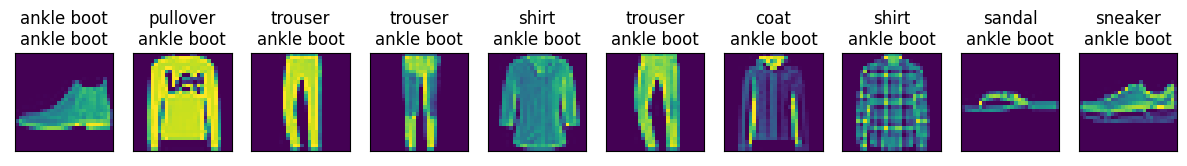

In [58]:
for X, y in test_iter:
    break
n = 10
trues = d2l.get_fashion_mnist_labels(y)
preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
d2l.show_images(
    X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

tensor(-4.6052)